In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exploratory Data Analysis (EDA)

### Reading the dataset

In [2]:
df = pd.read_csv('../Data/All lending loan club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv',low_memory=False) #entire file is read into the memeory at once

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(2260701, 151)

### Filter out loan status entries

In [5]:
df = df.loc[(df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Fully Paid')]

df.shape

(1345310, 151)

### Drop leak column

In [6]:
column_drop = [
    'acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
    'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 
    'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 
    'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'initial_list_status', 
    'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct', 'last_pymnt_amnt', 'last_pymnt_d', 
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 
    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 
    'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'out_prncp', 
    'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 
    'tot_coll_amt', 'tot_cur_bal', 'last_fico_range_high', 'last_fico_range_low', 'url', 'id', 'title', 
    'addr_state', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 
    'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
    'total_rev_hi_lim'
] # List of columns to drop

# Drop columns
df_drop = df.drop(columns=column_drop)
dropped_columns_count = len(column_drop)

print("After Dropping, the new DataFrame contains {} features and lost a total of {} features".format(df_drop.shape[1], dropped_columns_count))

After Dropping, the new DataFrame contains 86 features and lost a total of 65 features


### Drop columns that have only one number of unique value

In [7]:
# Finding unique values in each feature
nunique_value = df_drop.nunique()

# Finding columns with only one unique value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()

print(single_value_cols)

['policy_code', 'hardship_type', 'deferral_term', 'hardship_length']


In [8]:
# Drop columns with only one unique value
df_drop = df_drop.drop(columns = single_value_cols)

In [9]:
df_drop.shape

(1345310, 82)

### Dropping the features that has more than 50% of missing value

In [10]:
# Calculate percentage of missing values for each column
missing_data = df_drop.isnull().sum() / len(df_drop) * 100

# Filter columns with missing values less than 50%
missing_variable = missing_data[missing_data < 50].index.tolist()

# Columns with missing values more than 50%
drop_columns = list(set(df_drop.columns) - set(missing_variable))

# Drop columns based on missing data more than 50%
df_drop_nan = df_drop.drop(columns=drop_columns)

df_drop_nan.shape

(1345310, 27)

In [13]:
for col in df_drop_nan.columns:
    print(col)

loan_amnt
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
purpose
zip_code
dti
earliest_cr_line
fico_range_low
fico_range_high
open_acc
pub_rec
revol_bal
revol_util
total_acc
application_type
mort_acc
pub_rec_bankruptcies


In [14]:
# Function to remove outlier based on interquartile range
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    # Remove entries that are lower than fence low and larger than fence high
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

`loan_amnt`

In [17]:
df_drop_nan['loan_amnt'].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Amount in USD')]

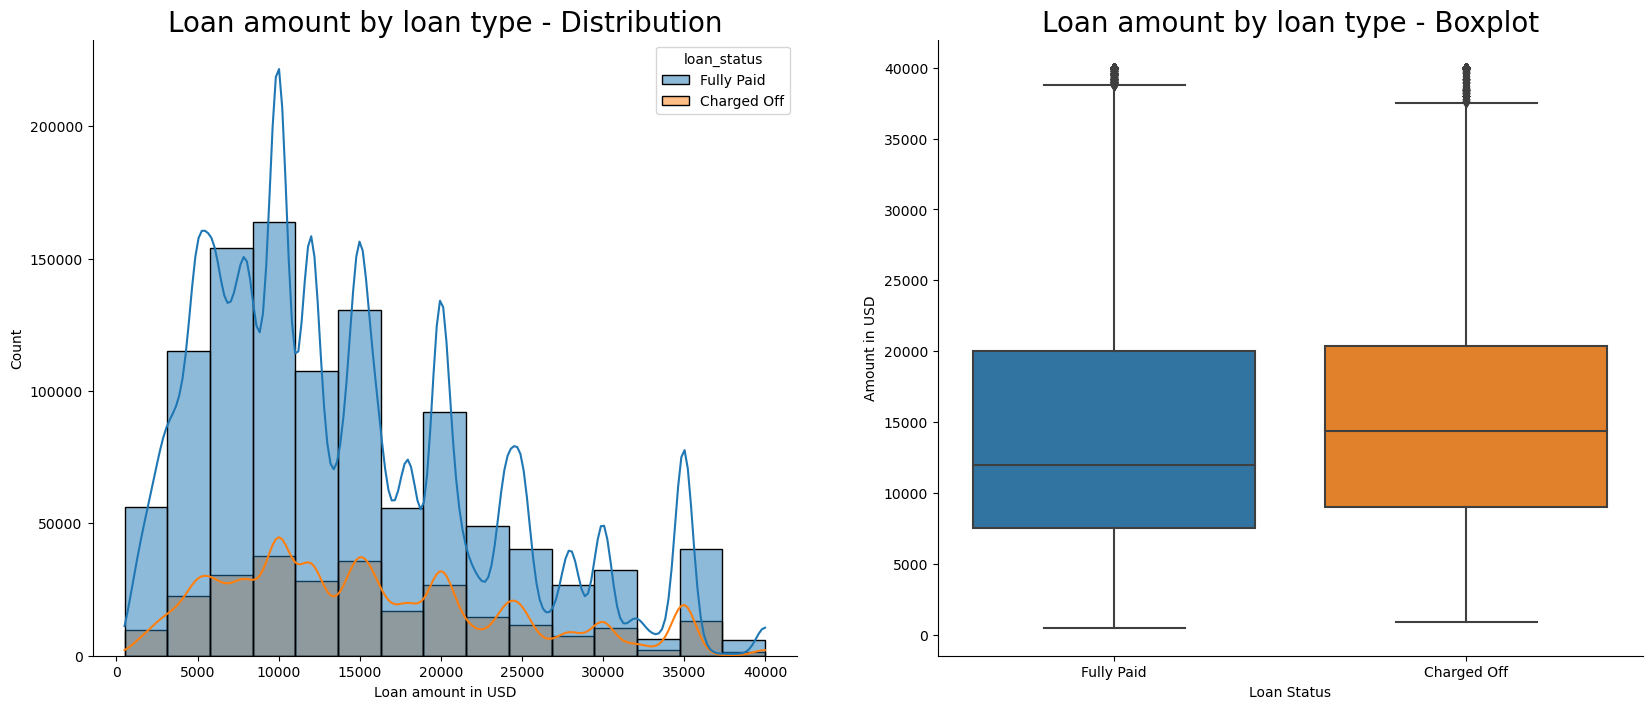

In [19]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Loan amount in USD', ylabel='')
ax[0].set_title('Loan amount by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Loan amount by loan type - Boxplot', size=20)

sns.histplot(data=df_drop_nan,x="loan_amnt",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=df_drop_nan,x="loan_status",y="loan_amnt",ax=ax[1]).set(xlabel='Loan Status',
                                                                     ylabel='Amount in USD')

As observed in the histogram plot, `loan_amnt`'s distribution is right skewed. From looking at the boxplot, the feature descriptively looks pretty much normal with relatively low number of outliers.

`revol_bal`

In [21]:
df_drop_nan['revol_bal'].describe()

count    1.345310e+06
mean     1.624811e+04
std      2.232817e+04
min      0.000000e+00
25%      5.943000e+03
50%      1.113400e+04
75%      1.975575e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'Amount in USD')]

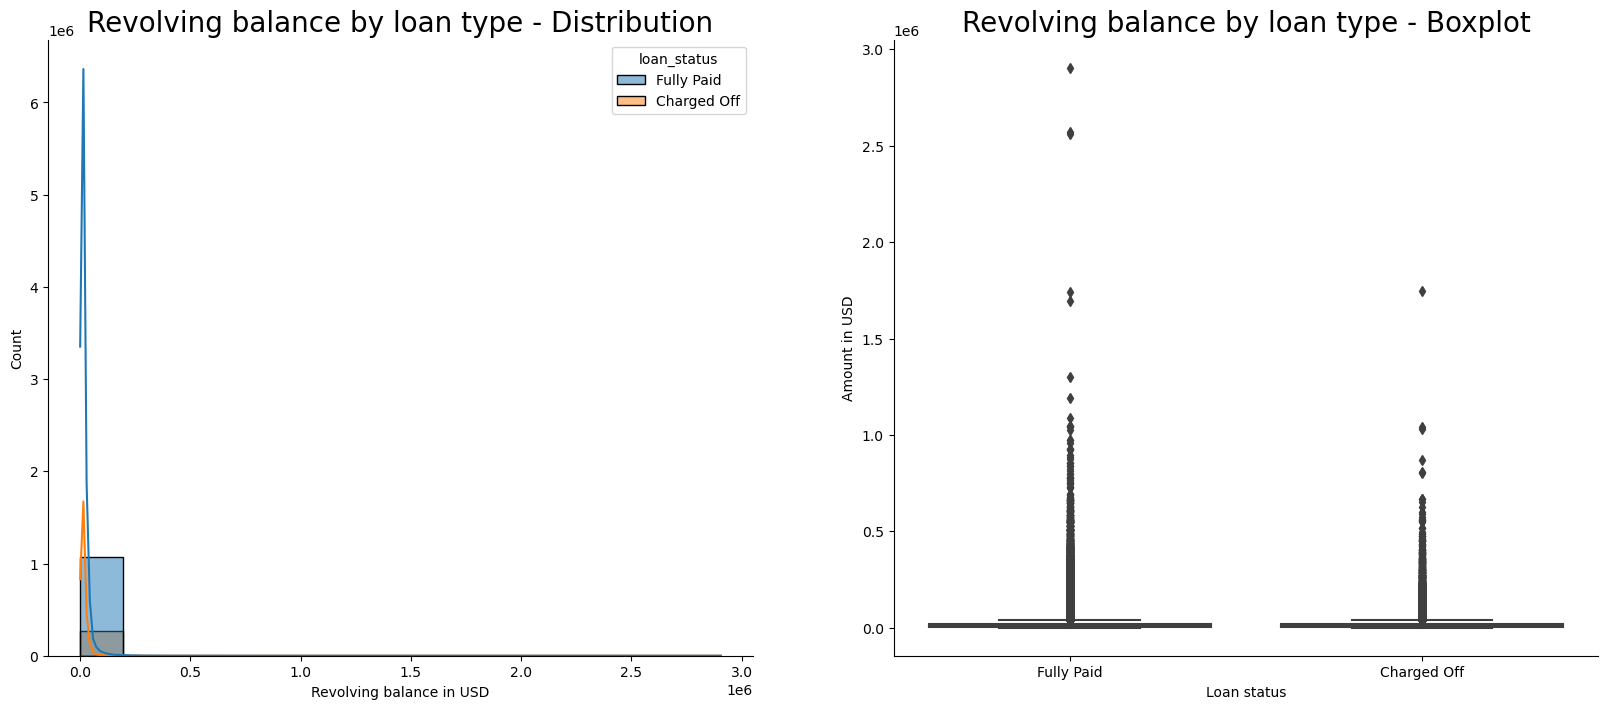

In [22]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Revolving balance in USD', ylabel='')
ax[0].set_title('Revolving balance by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Revolving balance by loan type - Boxplot', size=20)

sns.histplot(data=df_drop_nan,x="revol_bal",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=df_drop_nan,x="loan_status",y="revol_bal",ax=ax[1]).set(xlabel='Loan status',
                                                                     ylabel='Amount in USD')

By looking at the boxplot, it seems like there are a lot of outliers within the feature. For the sake of visualization, create a function to remove outliers from the feature.

[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'Amount in USD')]

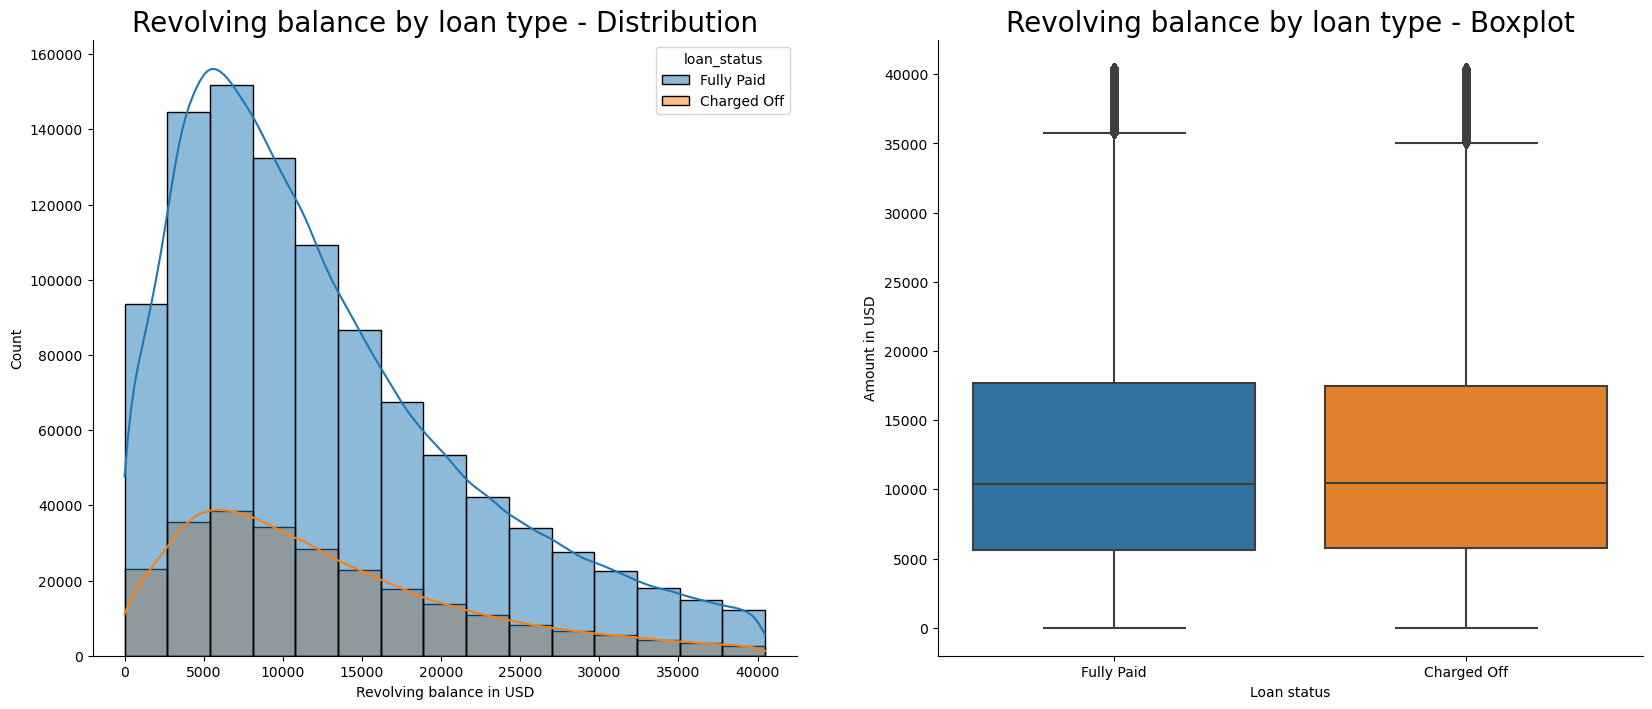

In [24]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Revolving balance in USD', ylabel='')
ax[0].set_title('Revolving balance by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Revolving balance by loan type - Boxplot', size=20)

sns.histplot(data=remove_outlier(df_drop_nan, 'revol_bal'),x="revol_bal",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=remove_outlier(df_drop_nan, 'revol_bal'),x="loan_status",y="revol_bal",ax=ax[1]).set(xlabel='Loan status',
                                                                     ylabel='Amount in USD')

The feature seems to be right skewed. This is a feature that might benefit from log transformation to normalize the data.

`fico_range_high`

In [29]:
df_drop_nan['fico_range_high'].describe()

count    1.345310e+06
mean     7.001852e+02
std      3.185316e+01
min      6.290000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64

[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'FICO score high range')]

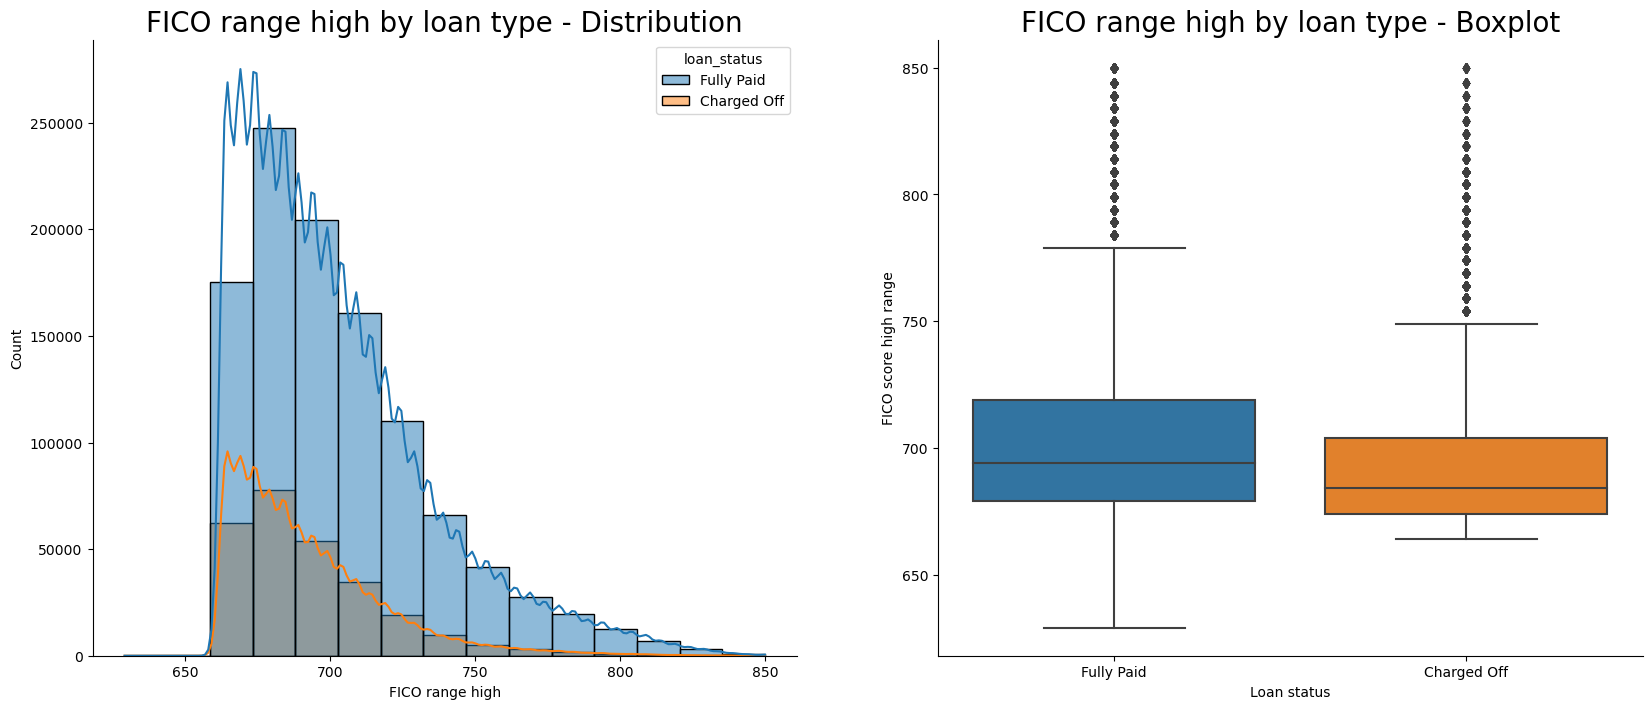

In [26]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='FICO range high', ylabel='')
ax[0].set_title('FICO range high by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('FICO range high by loan type - Boxplot', size=20)

sns.histplot(data=df_drop_nan,x="fico_range_high",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=df_drop_nan,x="loan_status",y="fico_range_high",ax=ax[1]).set(xlabel='Loan status',
                                                                     ylabel='FICO score high range')

`fico_range_low`

In [28]:
df_drop_nan['fico_range_low'].describe()

count    1.345310e+06
mean     6.961850e+02
std      3.185251e+01
min      6.250000e+02
25%      6.700000e+02
50%      6.900000e+02
75%      7.100000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64

[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'FICO score low range')]

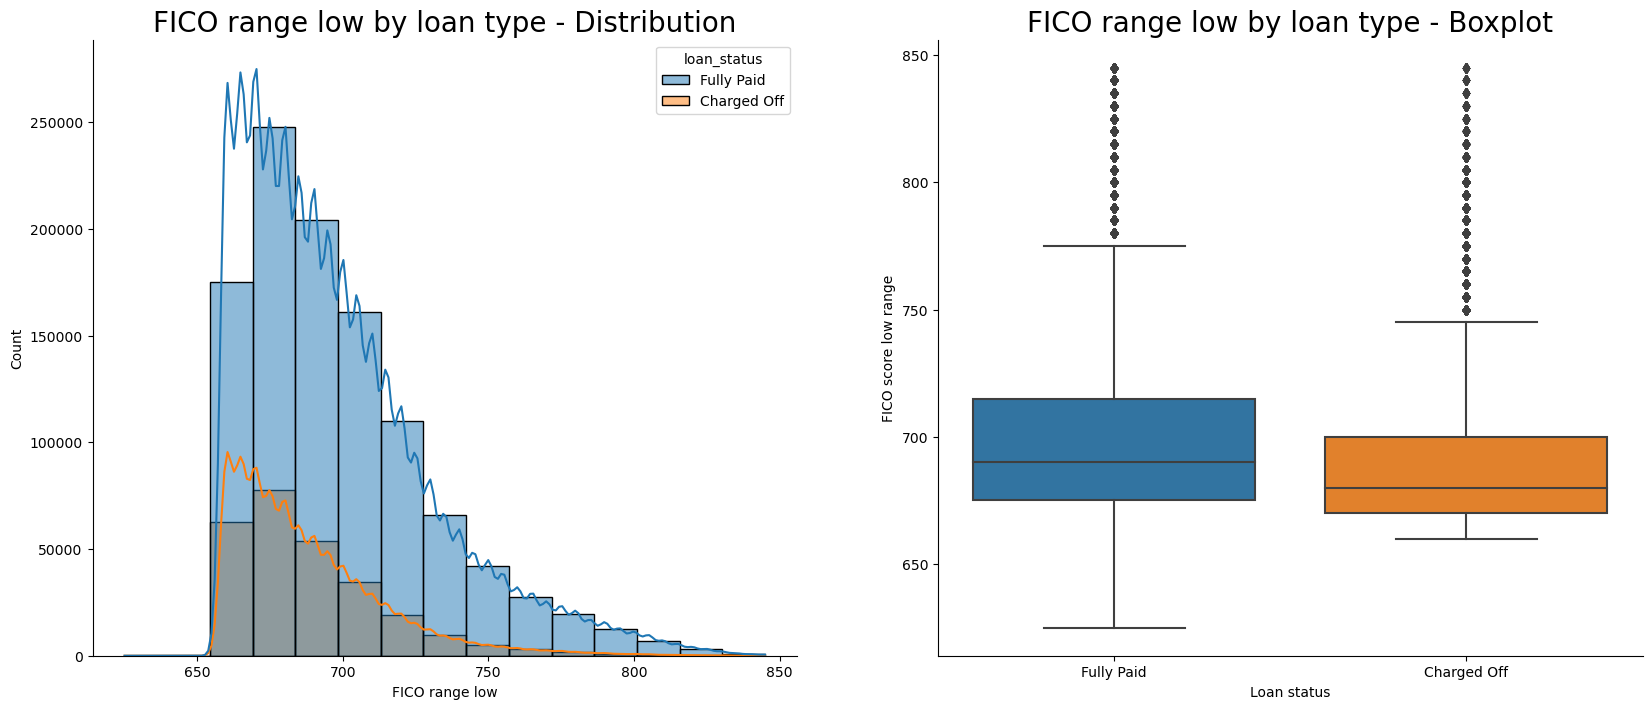

In [30]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='FICO range low', ylabel='')
ax[0].set_title('FICO range low by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('FICO range low by loan type - Boxplot', size=20)

sns.histplot(data=df_drop_nan,x="fico_range_low",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=df_drop_nan,x="loan_status",y="fico_range_low",ax=ax[1]).set(xlabel='Loan status',
                                                                     ylabel='FICO score low range')

`fico_range_high` and `fico_range_low` has pretty similar distribution. This is expected since FICO scores typically follow a range. Consider taking the average of these two features since it won't change their distribution all that much.

`purpose`

First, let's investigate the number of unique entries contained within the feature.

In [31]:
df_drop_nan['purpose'].nunique()

14

In [32]:
df_drop_nan['purpose'].unique().tolist()

['debt_consolidation',
 'small_business',
 'home_improvement',
 'major_purchase',
 'credit_card',
 'other',
 'house',
 'vacation',
 'car',
 'medical',
 'moving',
 'renewable_energy',
 'wedding',
 'educational']

Investigate the number of each loan applications on each loan `purpose` with respect to `loan_status`.

<Axes: xlabel='purpose', ylabel='count'>

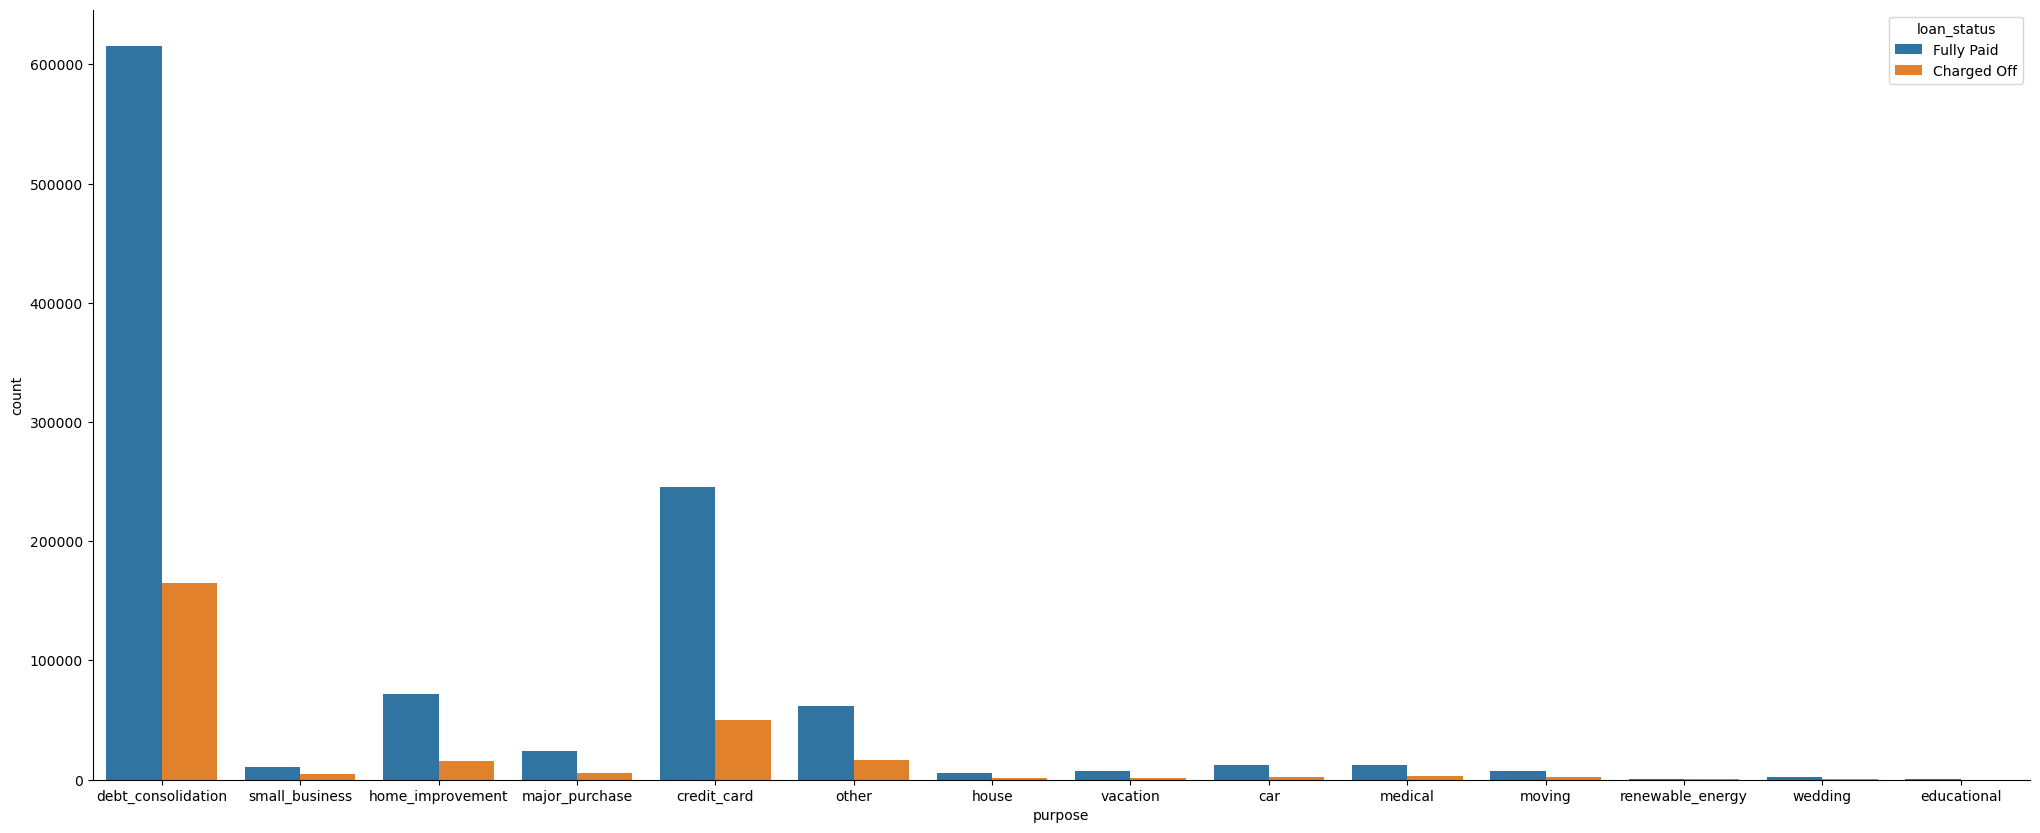

In [34]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.despine()
sns.countplot(data=df_drop_nan, x='purpose', hue='loan_status')

Based on the graph, `debt_consolidation`, `home_improvement`, and `credit_card` have the highest number of charged off loans. However, it is quite hard to conclude the percentage of charge off loans for each category. Therefore, we create a table calculating the percentage of charged off loans for each purpose.

In [38]:
df_co = df_drop_nan[df['loan_status'] == 'Charged Off'].groupby('purpose').count()[['loan_status']]

df_total = df_drop_nan.groupby('purpose').count()[['loan_status']]

percent_co = df_co / df_total * 100

percent_co.rename(columns={'loan_status': 'Percentage Charged Off Loans'}).reset_index()

,purpose,Percentage Charged Off Loans
0,car,14.679465
1,credit_card,16.927042
2,debt_consolidation,21.146938
3,educational,17.177914
4,home_improvement,17.715762
5,house,21.880601
6,major_purchase,18.599830
7,medical,21.775749
8,moving,23.354430
9,other,21.040128


`small_business`, `renewable_energy`, and `moving` have the highest percentage of charged off loans.

`dti`

In [40]:
df_drop_nan['dti'].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

`dti` should not be negative as a negative DTI ratio would imply either negative debt (which doesn't make sense in this context, as you can't owe negative money) or negative income (which would indicate that you are paying to work, rather than earning from work). Both scenarios are not feasible in standard financial practice. Let's inspect how many data points has a negative value.

In [43]:
df_drop_nan[df_drop_nan['dti'] < 0]['dti'].value_counts()

-1.0    2
Name: dti, dtype: int64

There are 2 data points within this feature having negative value. Further processing should be performed on this two instances. Recommend dropping these points as they don't represent the majority of the data.

[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'dti')]

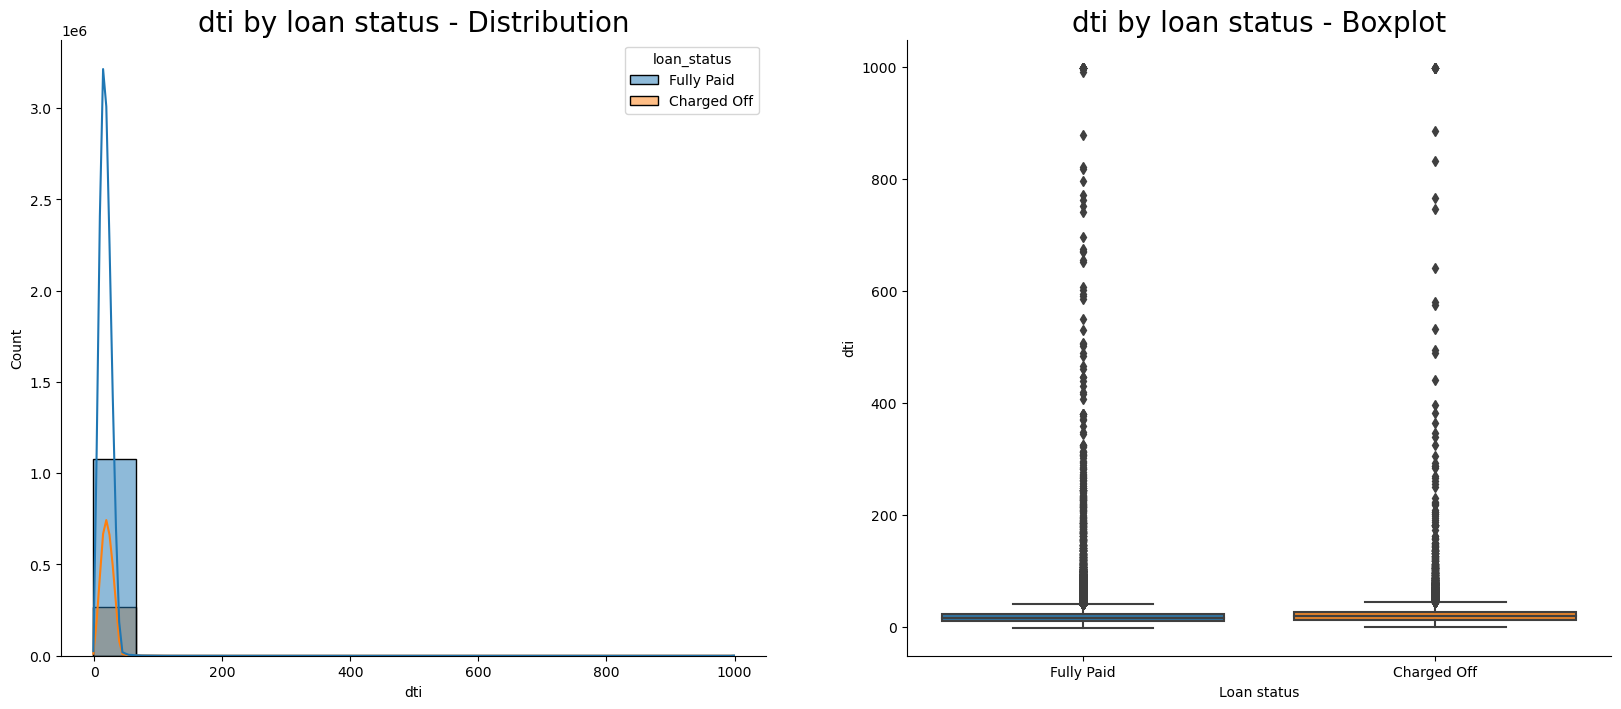

In [44]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='dti', ylabel='')
ax[0].set_title('dti by loan status - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('dti by loan status - Boxplot', size=20)

sns.histplot(data=df_drop_nan,x="dti",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=df_drop_nan,x="loan_status",y="dti",ax=ax[1]).set(xlabel='Loan status',
                                                                     ylabel='dti')

By looking at the boxplot, it seems like there are a lot of outliers within the feature. For the sake of visualization, create a function to remove outliers from the feature.

[Text(0.5, 0, 'Loan status'), Text(0, 0.5, 'dti')]

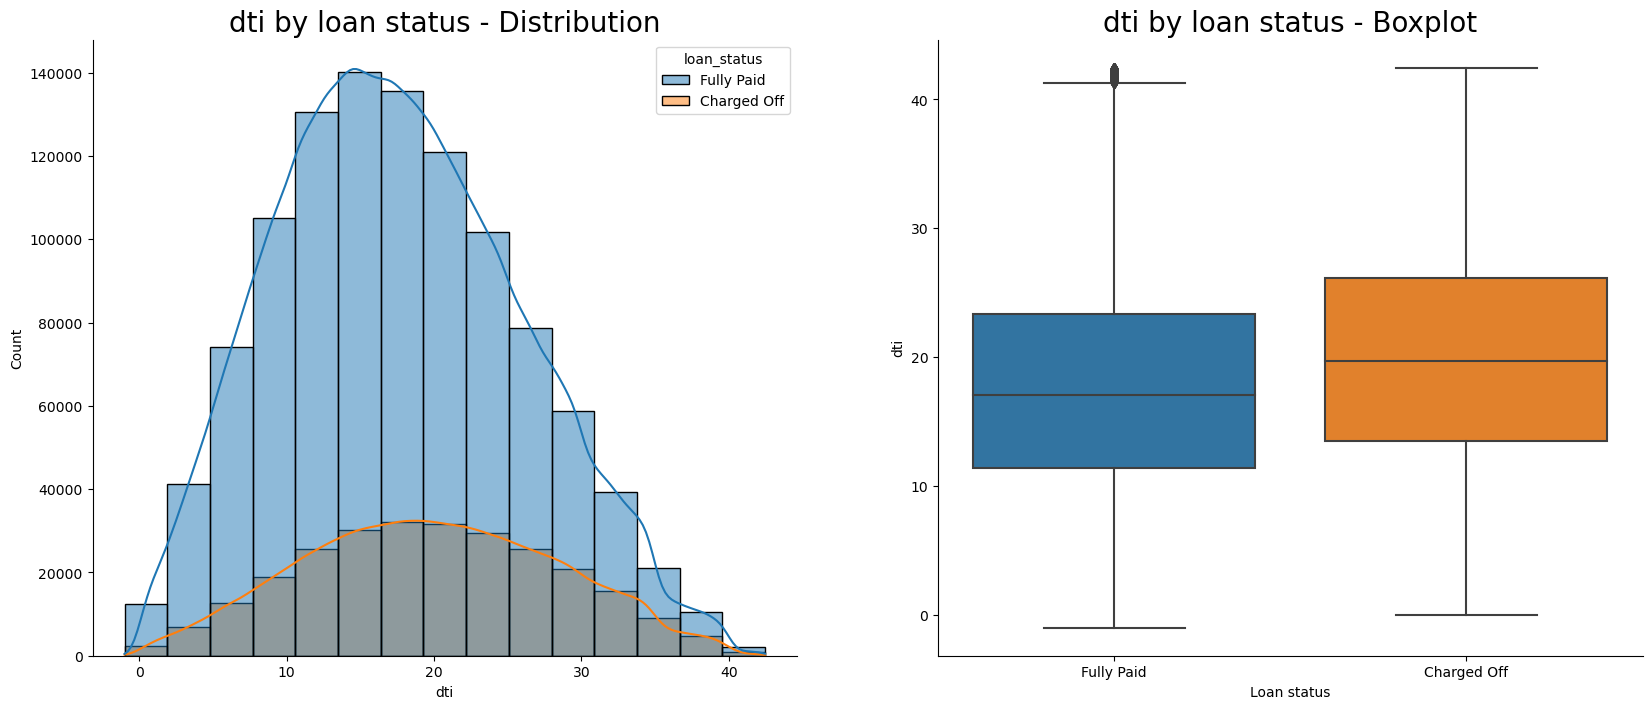

In [47]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='dti', ylabel='')
ax[0].set_title('dti by loan status - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('dti by loan status - Boxplot', size=20)

sns.histplot(data=remove_outlier(df_drop_nan, 'dti'),x="dti",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=remove_outlier(df_drop_nan, 'dti'),x="loan_status",y="dti",ax=ax[1]).set(xlabel='Loan status',
                                                                     ylabel='dti')

Initially, this feature is right skewed with numerous outliers. However, after removing the outliers, the distribution of `dti` seems quite normal.

`issue_d` 

Convert `issue_d` column to DateTime type

In [48]:
df_drop_nan['issue_d'] = pd.to_datetime(df_drop_nan['issue_d'])

Create a year column

In [51]:
df_drop_nan['year'] = df_drop_nan['issue_d'].dt.year

<Axes: xlabel='year', ylabel='count'>

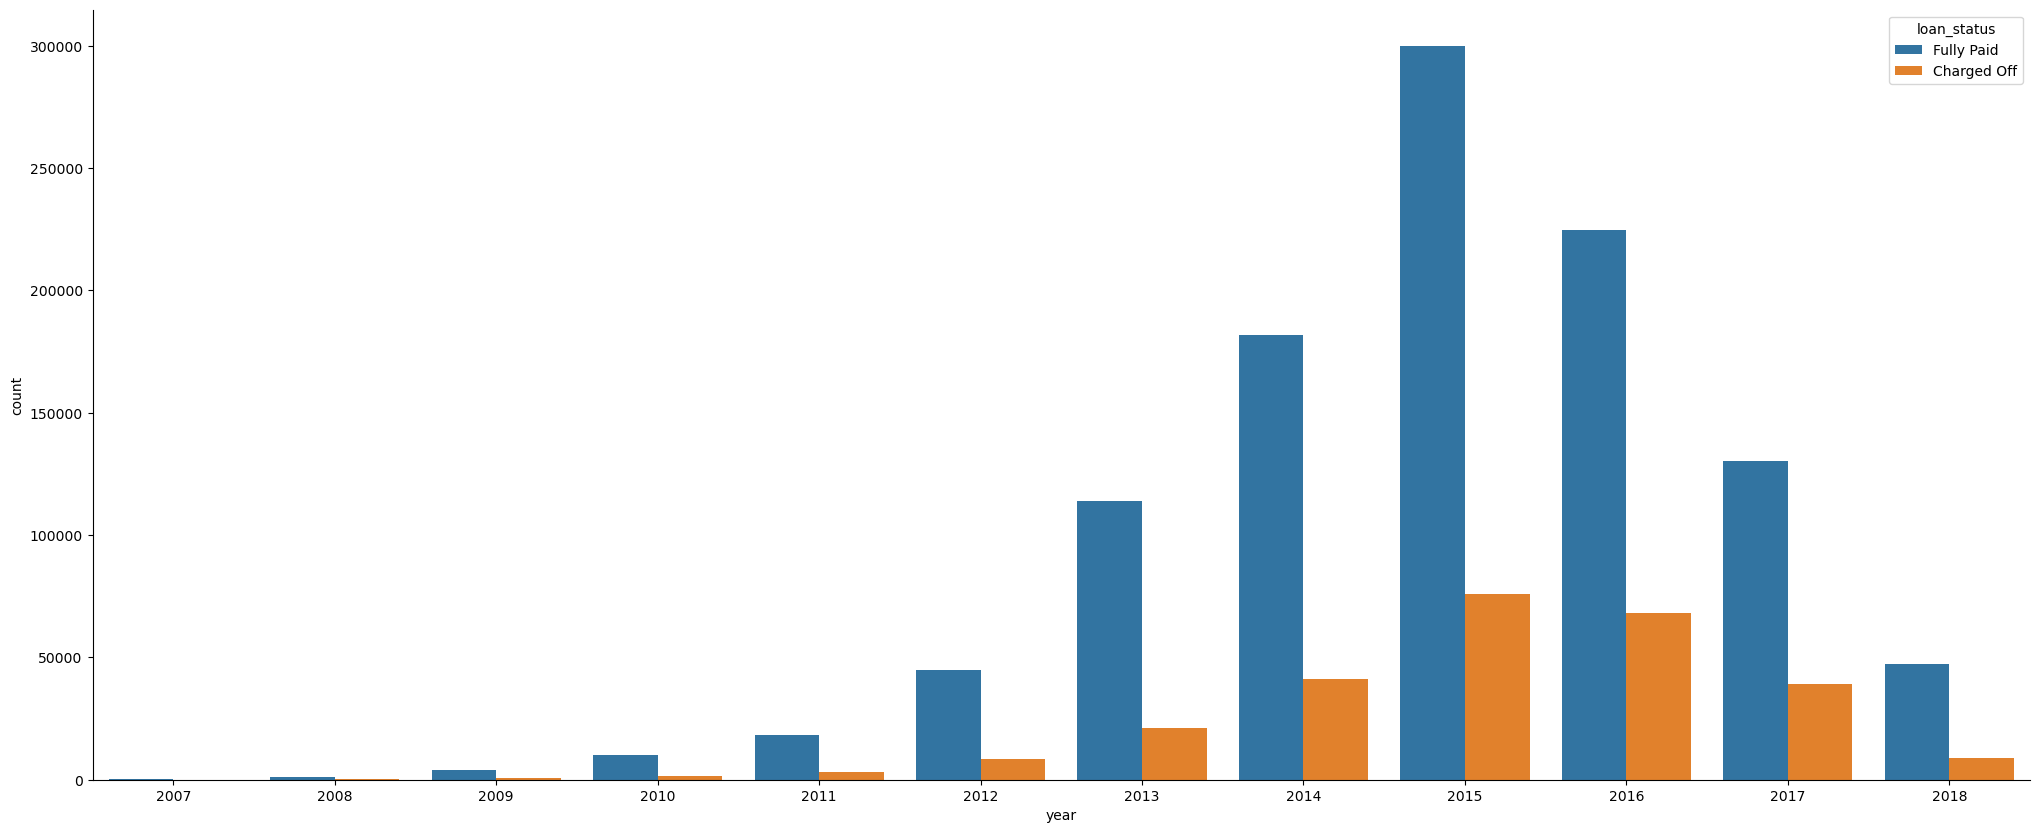

In [53]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.despine()
sns.countplot(data=df_drop_nan, x='year', hue='loan_status')

Based on the graph, the period from 2013 to 2017 has the highest number of loan applications. However, we can't see the percentage of charged off loans within each year. Let's create a table to calculate this.

In [55]:
df_co = df_drop_nan[df['loan_status'] == 'Charged Off'].groupby('year').count()[['loan_status']]

df_total = df_drop_nan.groupby('year').count()[['loan_status']]

percent_co = df_co / df_total * 100

percent_co.rename(columns={'loan_status': 'Percentage Charged Off Loans'}).reset_index()

,year,Percentage Charged Off Loans
0,2007,17.928287
1,2008,15.813060
2,2009,12.595420
3,2010,12.890083
4,2011,15.178859
5,2012,16.197275
6,2013,15.595976
7,2014,18.449409
8,2015,20.184798
9,2016,23.283236


Based on the table, `2015`, `2016`, and `2017` are the years having the